# Energy resolution after  delta-z effect correction

## DEMO Run7, esmeralda: 8757, 8758, 8759 @gpu1next


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon Apr 12 15:37:37 2021


### load data

In [56]:
def get_filename(run_number):
    datadir    = f"/home/jrenner/analysis/DEMO/run7/"
    run_number = str(run_number)
    filename   = datadir + f'/cdst_combined_{run_number}' + '.h5'
    return filename

In [57]:
runs      = [8757, 8758, 8759]
filenames = [get_filename(run) for run in runs]
dfts      = [nio.get_dfesme(fname) for fname in filenames]
dft       = pd.concat(dfts)

In [58]:
dft       = pd.concat(dfts)
len(dft)

3080650

### Inspect DF

In [59]:
columns = list(dft.columns)
print(columns)
#pltext.df_inspect(dft, columns[:-1], ncolumns = 3)

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map']


### selections and ranges

In [69]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.65, 0.75),
          'energy.ds'      : (1.60, 1.85),
          'energy.ph'      : (2.00, 3.00),
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.65, 0.75)
energy.ds (1.6, 1.85)
energy.ph (2.0, 3.0)


In [70]:
selections = nsel.Selections(dft, ranges)

In [71]:
def efficiencies(sels):
    xeffs = []
    ksel = sels[0]
    for isel in sels:
        ksel = ksel & isel
        xeffs.append(ut.efficiency(ksel))
    effs  = [100.*eff[0] for eff in xeffs]
    ueffs = [100.*eff[1] for eff in xeffs]
    return effs, ueffs

             name        eff     ueffs
0             nS2  27.062893  0.025313
1  numb_of_tracks  24.683168  0.024565
2           z_min  22.251505  0.023698
3           z_max  20.626426  0.023053
4  evt_out_of_map   4.730722  0.012095


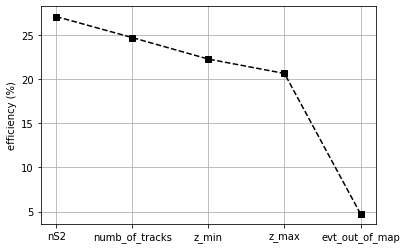

In [72]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'evt_out_of_map') 
sels        = [selections[selname] for selname in selnames]
effs, ueffs = efficiencies(sels)
plt.errorbar(selnames, effs, ueffs, ls = '--', marker = 's'); plt.grid(); plt.ylabel('efficiency (%)')
xdf = pd.DataFrame({'name' : selnames, 'eff': effs, 'ueffs' : ueffs})
print(xdf)

             name        eff     ueffs
0             nS2  27.062893  0.025313
1  numb_of_tracks  24.683168  0.024565
2           z_min  22.251505  0.023698
3           z_max  20.626426  0.023053
4           r_max   3.185237  0.010005


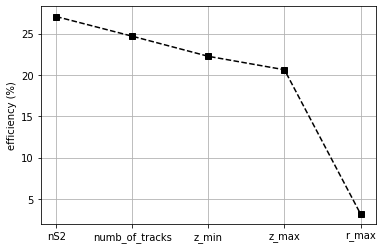

In [73]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max') 
sels        = [selections[selname] for selname in selnames]
effs, ueffs = efficiencies(sels)
plt.errorbar(selnames, effs, ueffs, ls = '--', marker = 's'); plt.grid(); plt.ylabel('efficiency (%)')
xdf = pd.DataFrame({'name' : selnames, 'eff': effs, 'ueffs' : ueffs})
print(xdf)

In [74]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max')
selections.logical_and(selnames, 'fidutial');


In [75]:
#pltext.df_inspect(dft[selections['fidutial']], columns[:-1], ncolumns = 3)

### Energy 

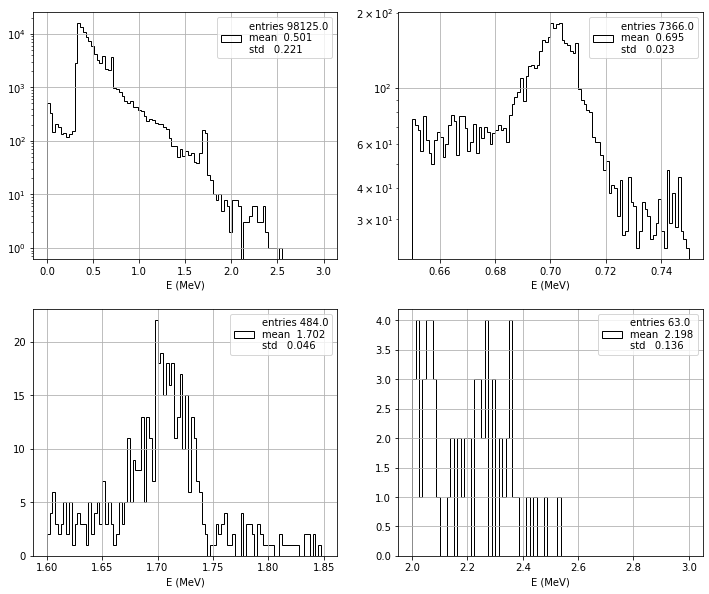

In [76]:
def plt_energies(enes, sel = None):

    xsel = sel if sel is not None else enes > np.min(enes)

    subplot = pltext.canvas(4, 2)
    subplot(1)
    pltext.hist(enes[xsel], 100, range = ranges['energy'], ylog = True, xylabels = 'E (MeV)'); 
    subplot(2)
    pltext.hist(enes[xsel], 100, range = ranges['energy.cs'], ylog = True, xylabels = 'E (MeV)');
    subplot(3)
    pltext.hist(enes[xsel], 100, range = ranges['energy.ds'], xylabels = 'E (MeV)');
    subplot(4)
    pltext.hist(enes[xsel], 80, range  = ranges['energy.ph'], xylabels = 'E (MeV)');


plt_energies(dft.energy, selections['fidutial'])
#plt_energies(dft.energy)

In [77]:
def plt_energies_fit(enes, bins, ranges, parameters, selections = None):

    nsize = len(ranges)
    subplot = pltext.canvas(nsize)
    
    selections = selections if selections is not None else nsize * [enes > np.min(enes)]
    
    epars = []
    for i in range(nsize):
        subplot(i + 1)
        xsel, xpars   = selections[i] & ut.in_range(enes, ranges[i]), parameters[i]
        _, _, _, pars, parscov, _= pltext.hfit(enes[xsel], bins, 'gaus+poly.1', 
                                               p0 = xpars, formate = '7.4f', 
                                               residuals = True);
        epars.append((pars, parscov))
 
    dpars = {}
    dpars['energy'] = [ipars[1] for ipars, iparscov in epars]
    dpars['sigma']  = [ipars[2] for ipars, iparscov in epars]
    dpars['usigma'] = [iparscov[2] for ipars, iparscov in epars]
    dpars['R']      = [235. * ipars[2]/ipars[1] for ipars, iparscov in epars]
    dpars['uR']     = [235. * iparscov[2]/ipars[1] for ipars, iparscov in epars]


    dferes = pd.DataFrame(dpars)
    
    return dferes

fidutial cuts
energy 
      energy     sigma    usigma          R         uR
0  0.699014  0.008914  0.000289   2.996689   0.097039
1  1.701619  0.020500  0.001620   2.831178   0.223701
2  2.387930  0.691463  0.365050  68.047968  35.925137
fidutial cuts


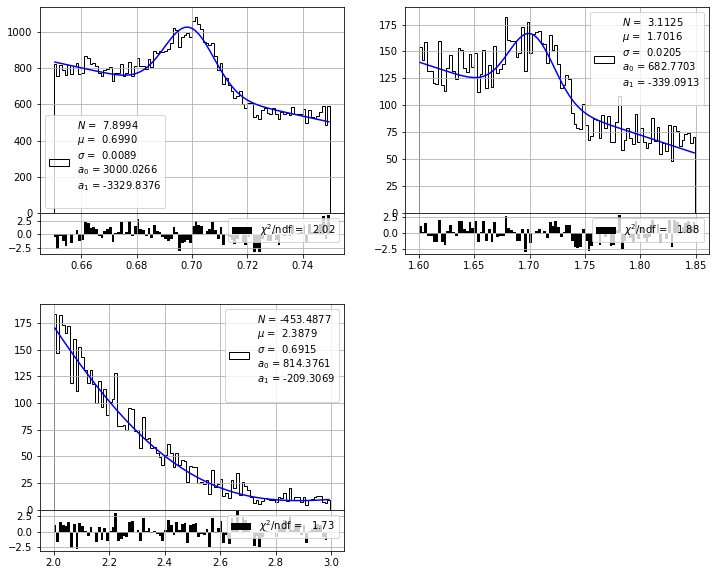

In [79]:
bins    = 100
xsel    = selections['numb_of_tracks']
xranges = (ranges['energy.cs'], ranges['energy.ds'], ranges['energy.ph'])
xpars0  = ((65.,  0.7, 0.013,  553., 1.9), (65.,  1.7, 0.013,  553., 1.9), (10.,  2.7, 0.013,  10., 1.))
dfenes0 = plt_energies_fit(dft.energy, bins, xranges, xpars0, 3*[xsel])
print('fidutial cuts')
print('energy \n', dfenes0)
print('fidutial cuts')

fidutial cuts
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.701500  0.008277  0.000259  2.772933  0.086900
1  1.709573  0.016830  0.001614  2.313427  0.221829
2  2.700000  0.013000       inf  1.131481       inf


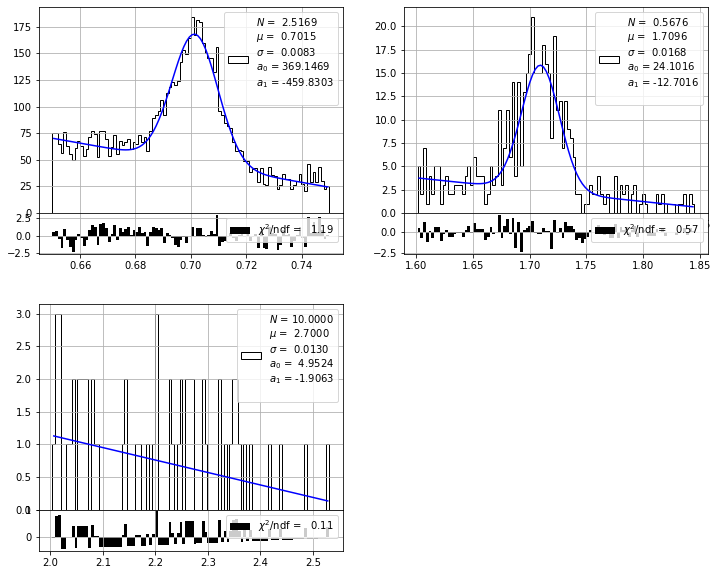

In [83]:
bins    = 100
xsel    = selections['fidutial']
xranges = [ranges['energy.cs'], ranges['energy.ds'], (2.0, 3.)]
xpars0  = ((65.,  0.7, 0.013,  553., 1.9), (65.,  1.7, 0.013,  553., 1.9), (10.,  2.7, 0.013,  10., 1.))
#xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.75, 0.01,  -5, 13.))
dfenes1 = plt_energies_fit(dft.energy, bins, xranges, xpars0, 3*[xsel,])
print('fidutial cuts')
print('correced by dz-effect energy \n', dfenes1)

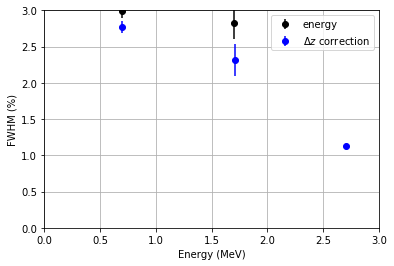

In [84]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');

### Delta Z- Effect

In [227]:
import hipy.histos as histos

def select_profile_in_sigma(x, y, nbins, xrange = None, yrange = None, nsigmas = 2., niter = 1):
            
    sel     = ut.in_range(x, xrange) & ut.in_range(y, yrange)
    
    def _sel(x, y, xedges, ymed, ystd):
        ipos  = np.digitize(x, xedges) - 1
        ipos  = np.minimum(ipos, nbins - 1)
        ipos  = np.maximum(0, ipos)
        #print(np.min(ipos), np.max(ipos))
        return abs(y - ymed[ipos]) / ystd[ipos] < nsigmas
        #return np.array([_delta(yi, ipos) < nsigma for yi, ipos in zip(y, pos)])
    
    for i in range(niter):
        xp, yp = x[sel], y[sel]
        ysize, xedges, ymed, ystd, yumed = histos.hprofile(xp, yp, nbins, xrange, yrange)
        sel = _sel(x, y, xedges, ymed, ystd)
        print(i, np.sum(sel))
        
    return sel
    

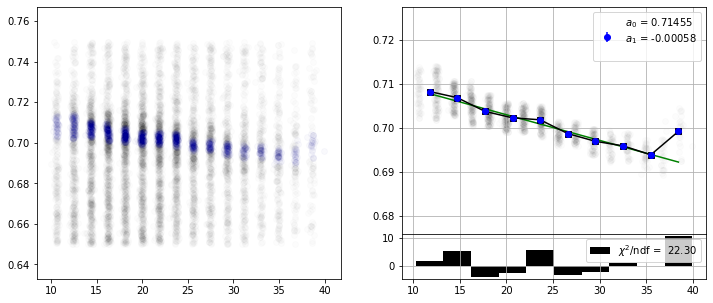

In [251]:
sel   = selections['fidutial'] & selections['energy.cs'] & ut.in_range(dft.dz_track, (10., 40.))
nbins = 10

x, y   = dft.dz_track[sel].values, dft.energy[sel].values

xsel = histos.in_nsigmas_of_profile(x, y, nbins, nsigmas = 1.5, niter = 10)

subplot = pltext.canvas(2)

subplot(1)
plt.scatter(x      , y      , alpha = 0.01, color = 'black')
plt.scatter(x[xsel], y[xsel], alpha = 0.01, color = 'blue')
subplot(2)
plt.scatter(x[xsel], y[xsel], alpha = 0.01)
pltext.hprofile(x[xsel], y[xsel], nbins, marker = 's');
pltext.hfitprofile(x[xsel], y[xsel], nbins, 'poly.1', formate = '6.5f', residuals = True);

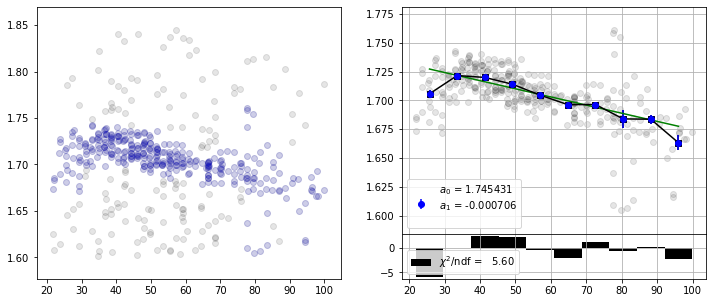

In [260]:
sel   = selections['fidutial'] & selections['energy.ds'] & ut.in_range(dft.dz_track, (20., 100.))
nbins = 10

x, y   = dft.dz_track[sel].values, dft.energy[sel].values

xsel = histos.in_nsigmas_of_profile(x, y, nbins, nsigmas = 2., niter = 10)

subplot = pltext.canvas(2)

subplot(1)
plt.scatter(x      , y      , alpha = 0.1, color = 'black')
plt.scatter(x[xsel], y[xsel], alpha = 0.1, color = 'blue')
subplot(2)
plt.scatter(x[xsel], y[xsel], alpha = 0.1)
pltext.hprofile(x[xsel], y[xsel], nbins, marker = 's');
pltext.hfitprofile(x[xsel], y[xsel], nbins, 'poly.1', formate = '6.6f', residuals = True);

fidutial cuts
correced by dz-effect energy 
      energy     sigma        usigma         R            uR
0  0.711326  0.006706      0.000193  2.215332  6.364302e-02
1  1.765333  0.011758      0.000988  1.565186  1.315141e-01
2  2.701034  0.003030  32348.855647  0.263579  2.814471e+06


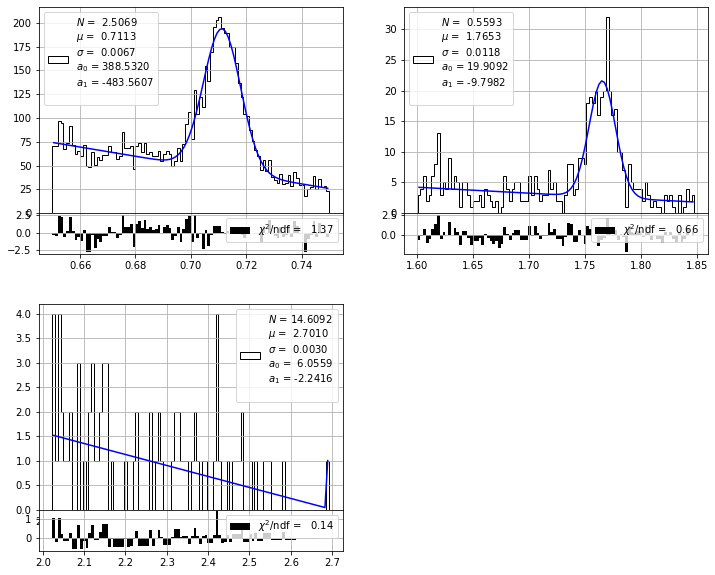

In [292]:
bins    = 100
xsel    = selections['fidutial']
dft.enecor = nio.energy_correction(dft.energy, dft.dz_track, 6.0e-4)
xranges = [ranges['energy.cs'], ranges['energy.ds'], (2.0, 3.)]
xpars0  = ((65.,  0.7, 0.013,  553., 1.9), (65.,  1.75, 0.013,  553., 1.9), (10.,  2.7, 0.013,  10., 1.))
#xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.75, 0.01,  -5, 13.))
dfenes1 = plt_energies_fit(dft.enecor, bins, xranges, xpars0, 3*[xsel,])
print('fidutial cuts')
print('correced by dz-effect energy \n', dfenes1)

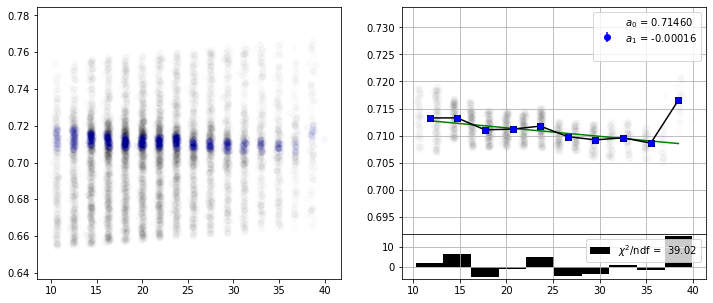

In [293]:
sel   = selections['fidutial'] & selections['energy.cs'] & ut.in_range(dft.dz_track, (10., 40.))
nbins = 10

x, y   = dft.dz_track[sel].values, dft.enecor[sel].values

xsel = histos.in_nsigmas_of_profile(x, y, nbins, nsigmas = 1.5, niter = 10)

subplot = pltext.canvas(2)

subplot(1)
plt.scatter(x      , y      , alpha = 0.01, color = 'black')
plt.scatter(x[xsel], y[xsel], alpha = 0.01, color = 'blue')
subplot(2)
plt.scatter(x[xsel], y[xsel], alpha = 0.01)
pltext.hprofile(x[xsel], y[xsel], nbins, marker = 's');
pltext.hfitprofile(x[xsel], y[xsel], nbins, 'poly.1', formate = '6.5f', residuals = True);

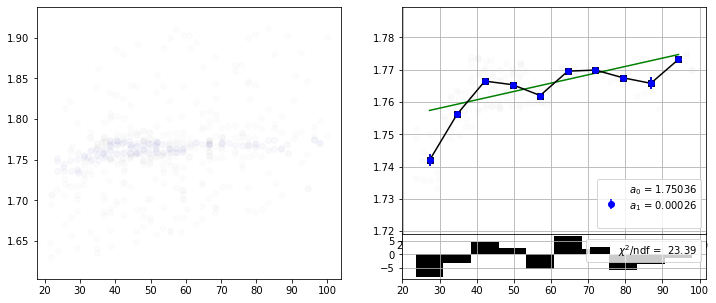

In [294]:
sel   = selections['fidutial'] & selections['energy.ds'] & ut.in_range(dft.dz_track, (20., 100.))
nbins = 10

x, y   = dft.dz_track[sel].values, dft.enecor[sel].values

xsel = histos.in_nsigmas_of_profile(x, y, nbins, nsigmas = 1.5, niter = 10)

subplot = pltext.canvas(2)

subplot(1)
plt.scatter(x      , y      , alpha = 0.01, color = 'black')
plt.scatter(x[xsel], y[xsel], alpha = 0.01, color = 'blue')
subplot(2)
plt.scatter(x[xsel], y[xsel], alpha = 0.01)
pltext.hprofile(x[xsel], y[xsel], nbins, marker = 's');
pltext.hfitprofile(x[xsel], y[xsel], nbins, 'poly.1', formate = '6.5f', residuals = True);

### extra selection in $\Delta z$ range

fidutial cuts with delta-z range
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.682885  0.003550  0.000025  1.221535  0.008729
1  1.669066  0.007402  0.000145  1.042238  0.020431
2  2.767156  0.011869  0.000745  1.007930  0.063233


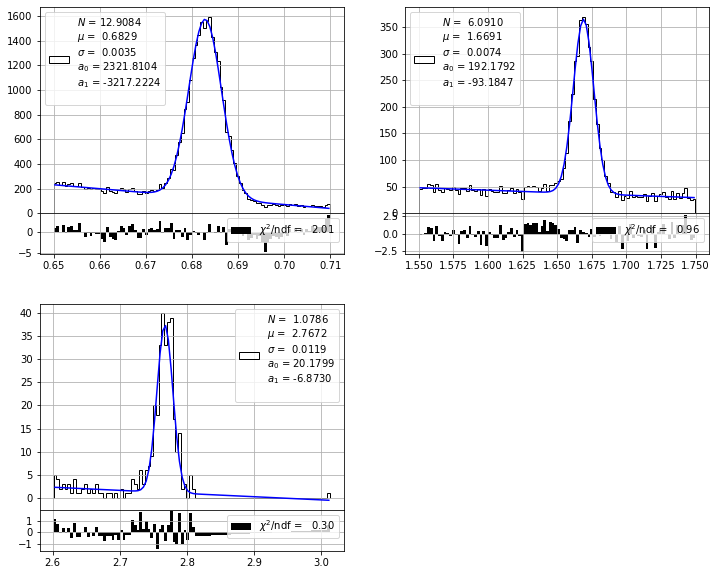

In [16]:
bins  = 100
xsels = (selections.logical_and(('fidutial', 'dz_track.cs')), 
         selections.logical_and(('fidutial', 'dz_track.ds')), 
         selections.logical_and(('fidutial', 'dz_track.ph')))
xranges = [ranges['enecor.cs'], ranges['enecor.ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (10.,  1.65, 0.013,  1., 50), (10.,  2.75, 0.01,  1., 10.))
dfenes1 = plt_energies_fit(dft.enecor, bins, xranges, xpars0, xsels)
print('fidutial cuts with delta-z range')
print('correced by dz-effect energy \n', dfenes1)

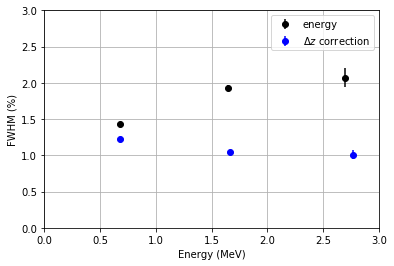

In [17]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');